In [2]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pydicom as dcm
%matplotlib inline 
import os
import glob, pylab
in_path = '/home/bif/Hello/stage_1_train_images/'


In [3]:
class_info_df = pd.read_csv('/home/bif/Hello/stage_1_detailed_class_info.csv')
train_labels_df = pd.read_csv('/home/bif/Hello/stage_1_train_labels.csv')  

In [4]:
print("Detailed class info -  rows:",class_info_df.shape[0]," columns:", class_info_df.shape[1])
print("Train labels -  rows:",train_labels_df.shape[0]," columns:", train_labels_df.shape[1])


Detailed class info -  rows: 28989  columns: 2
Train labels -  rows: 28989  columns: 6


In [5]:
class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [6]:
len(class_info_df)

28989

In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(train_labels_df)

,Total,Percent
height,20025,69.077926
width,20025,69.077926
y,20025,69.077926
x,20025,69.077926
Target,0,0.000000
patientId,0,0.000000


In [8]:
def get_feature_distribution(data, feature): 
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        #percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {}" .format(label, count))

get_feature_distribution(class_info_df, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11500
Lung Opacity                  :   8964
Normal                        :   8525


In [9]:
train_class_df = pd.concat([train_labels_df, 
                        class_info_df.drop('patientId',1)], 1)
print(train_class_df.shape[0], 'combined cases')
train_class_df.sample(3)

28989 combined cases


,patientId,x,y,width,height,Target,class
10995,7354ff46-3089-4ca6-8249-b0bb9efc9381,NaN,NaN,NaN,NaN,0,Normal
19936,b7f3190f-8ffa-490a-a429-826965114a3d,NaN,NaN,NaN,NaN,0,Normal
2159,2910d4e1-6826-4b3a-b24b-be04b8cb899c,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [10]:
image_sample_path = os.listdir('/home/bif/Hello/stage_1_train_images/')[:5]
print(image_sample_path)

['da52346f-930f-4d7f-9848-fe26a7c0a727.dcm', 'fffb2395-8edd-4954-8a89-ffe2fd329be3.dcm', 'b99b5a9a-d2cc-4e46-a419-cc7f1006dedd.dcm', '09547f4f-c52e-4fd7-8738-0e01e6277034.dcm', '7764c030-6b66-46a7-8768-1ea7ae381015.dcm']


In [11]:
print("Unique patientId in  train_class_df: ", train_class_df['patientId'].nunique())

Unique patientId in  train_class_df:  25684


In [12]:
train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [13]:
box_df = train_class_df.groupby('patientId').\
    size().\
    reset_index(name='boxes')
train_class_df = pd.merge(train_class_df, box_df, on='patientId')
box_df.\
    groupby('boxes').\
    size().\
    reset_index(name='patients')

,boxes,patients
0,1,22506
1,2,3062
2,3,105
3,4,11


In [14]:
def create_file_link(data):
    Image_data = {}
    for id in data['patientId']:
        dicom_file_path = "/home/bif/Hello/stage_1_train_images/" + str(id) + '.dcm'
        Image_data[id] = dicom_file_path
    return Image_data
def show_dicom_images(data):
    data_list = []
    Image_data = create_file_link(data=data)
    img_data = list(Image_data.keys())
    #f, ax = plt.subplots(3,3, figsize=(16,18))
    #image_sample_path = os.listdir('stage_1_train_images/')
    i = 0
    #data_keys = list(Image_data.keys())
    for key in img_data:
        imagePath = Image_data[key]
        data_row_img_data = dcm.read_file(imagePath)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        view_position = data_row_img_data.ViewPosition
        body_part = data_row_img_data.BodyPartExamined
        #path = create_file_link(train_class_df).values()
        l = list([img_data[i],modality,age,sex,view_position,body_part])
        data_list.append(l)
        i = i+1
    all_data = pd.DataFrame(data_list,columns=['patientId','modality','age','sex','view_position','body_part'])
    return all_data


In [15]:
df = show_dicom_images(train_class_df)

In [16]:
path = list(create_file_link(train_class_df).values())

In [17]:
df['path'] = pd.DataFrame(path)

In [18]:
len(path)

25684

In [19]:
df

,patientId,modality,age,sex,view_position,body_part,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,CR,51,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/0004cfab-...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,CR,48,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/00313ee0-...
2,00322d4d-1c29-4943-afc9-b6754be640eb,CR,19,M,AP,CHEST,/home/bif/Hello/stage_1_train_images/00322d4d-...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,CR,28,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/003d8fa0-...
4,00436515-870c-4b36-a041-de91049b9ab4,CR,32,F,AP,CHEST,/home/bif/Hello/stage_1_train_images/00436515-...
5,00569f44-917d-4c86-a842-81832af98c30,CR,54,M,AP,CHEST,/home/bif/Hello/stage_1_train_images/00569f44-...
6,006cec2e-6ce2-4549-bffa-eadfcd1e9970,CR,78,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/006cec2e-...
7,00704310-78a8-4b38-8475-49f4573b2dbb,CR,75,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/00704310-...
8,008c19e8-a820-403a-930a-bc74a4053664,CR,59,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/008c19e8-...
9,009482dc-3db5-48d4-8580-5c89c4f01334,CR,63,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/009482dc-...


In [19]:
final_dataframe = df.merge(train_class_df, how ='left',on='patientId')

In [20]:
len(final_dataframe)

28989

In [21]:
final_dataframe

,patientId,modality,age,sex,view_position,body_part,path,x,y,width,height,Target,class,boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,CR,51,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/0004cfab-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,CR,48,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/00313ee0-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,CR,19,M,AP,CHEST,/home/bif/Hello/stage_1_train_images/00322d4d-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,CR,28,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/003d8fa0-...,NaN,NaN,NaN,NaN,0,Normal,1
4,00436515-870c-4b36-a041-de91049b9ab4,CR,32,F,AP,CHEST,/home/bif/Hello/stage_1_train_images/00436515-...,264.0,152.0,213.0,379.0,1,Lung Opacity,2
5,00436515-870c-4b36-a041-de91049b9ab4,CR,32,F,AP,CHEST,/home/bif/Hello/stage_1_train_images/00436515-...,562.0,152.0,256.0,453.0,1,Lung Opacity,2
6,00569f44-917d-4c86-a842-81832af98c30,CR,54,M,AP,CHEST,/home/bif/Hello/stage_1_train_images/00569f44-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,CR,78,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/006cec2e-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,CR,75,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/00704310-...,323.0,577.0,160.0,104.0,1,Lung Opacity,2
9,00704310-78a8-4b38-8475-49f4573b2dbb,CR,75,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/00704310-...,695.0,575.0,162.0,137.0,1,Lung Opacity,2


In [19]:
'''PathDicom = "stage_1_train_images/"

lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower(): 
            lstFilesDCM.append(os.path.join(dirName,filename))
            
            
# Get ref file
RefDs = dcm.read_file(lstFilesDCM[0])

# Load dimensions based on the number of rows, columns, and slices (along the Z axis)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))

# Load spacing values (in mm)
ConstPixelSpacing = (float(RefDs.PixelSpacing[0]), float(RefDs.PixelSpacing[1]))




# The array is sized based on 'ConstPixelDims'
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)


# loop through all the DICOM files
for filenameDCM in lstFilesDCM:
    # read the file
    ds = dcm.read_file(filenameDCM)
    # store the raw image data
    ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array  '''

In [21]:
ArrayDicom[:,:,3000]

array([[  0,   5,  14, ..., 133, 140, 110],
       [  0,   7,  17, ..., 231, 234, 201],
       [  0,   7,  18, ..., 225, 226, 189],
       ...,
       [  0,  13,  43, ..., 165, 162, 158],
       [  1,  10,  34, ..., 124, 122, 119],
       [  0,   0,   4, ...,   0,   0,   0]], dtype=uint8)

In [22]:
 def parse_data(df):
    extract_box = lambda row: [row['y'], row['x'], row['height'], row['width']]

    parsed = {}
    for n, row in df.iterrows():
        # --- Initialize patient entry into parsed 
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'dicom': '/home/bif/Hello/stage_1_train_images/%s.dcm' % pid,
                'label': row['Target'],
                'boxes': []}

        # --- Add box if opacity is present
        if parsed[pid]['label'] == 1:
            parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [23]:
parsed = parse_data(final_dataframe)

In [24]:
def draw(data):
    """
    Method to draw single patient with bounding box(es) if present 

    """
    # --- Open DICOM file
    d = dcm.read_file(data['dicom'])
    im = d.pixel_array

    # --- Convert from single-channel grayscale to 3-channel RGB
    im = np.stack([im] * 3, axis=2)

    # --- Add boxes with random color if present
    for box in data['boxes']:
        rgb = np.floor(np.random.rand(3) * 256).astype('int')
        im = overlay_box(im=im, box=box, rgb=rgb, stroke=6)

    pylab.imshow(im, cmap=pylab.cm.gist_gray)
    pylab.axis('off')

def overlay_box(im, box, rgb, stroke=1):
    """
    Method to overlay single box on image

    """
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

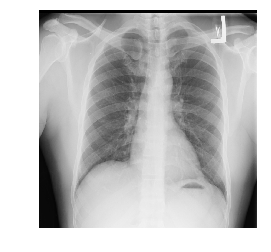

In [25]:
draw(parsed['01a4059c-22f7-4f51-8a27-50aff0b3aeb3'])

In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
final_dataframe['class_idx'] = class_enc.fit_transform(final_dataframe['class'])
oh_enc = OneHotEncoder(sparse=False)
final_dataframe['class_vec'] = oh_enc.fit_transform(
    final_dataframe['class_idx'].values.reshape(-1, 1)).tolist() 


In [27]:
final_dataframe.head()

,patientId,modality,age,sex,view_position,body_part,path,x,y,width,height,Target,class,boxes,class_idx,class_vec
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,CR,51,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/0004cfab-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,"[0.0, 1.0, 0.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,CR,48,F,PA,CHEST,/home/bif/Hello/stage_1_train_images/00313ee0-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,"[0.0, 1.0, 0.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,CR,19,M,AP,CHEST,/home/bif/Hello/stage_1_train_images/00322d4d-...,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,1,"[0.0, 1.0, 0.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,CR,28,M,PA,CHEST,/home/bif/Hello/stage_1_train_images/003d8fa0-...,NaN,NaN,NaN,NaN,0,Normal,1,2,"[0.0, 0.0, 1.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,CR,32,F,AP,CHEST,/home/bif/Hello/stage_1_train_images/00436515-...,264.0,152.0,213.0,379.0,1,Lung Opacity,2,0,"[1.0, 0.0, 0.0]"


In [28]:
from sklearn.model_selection import train_test_split
image_df = final_dataframe.groupby('patientId').apply(lambda x: x.sample(1))
raw_train_df, valid_df = train_test_split(image_df, test_size=0.15, random_state=2000,
                                    stratify=image_df['class'])
print(raw_train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(21831, 16) training data
(3853, 16) validation data


In [29]:
BASE_MODEL= 'DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (224, 224) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 24 # [1, 8, 16, 24]
DENSE_COUNT = 128 # [32, 64, 128, 256]
DROPOUT = 0.25 # [0, 0.25, 0.5]
LEARN_RATE = 1e-4 # [1e-4, 1e-3, 4e-3]
TRAIN_SAMPLES = 13000 # [3000, 6000, 15000]
TEST_SAMPLES = 800
USE_ATTN = False # [True, False]

In [30]:
train_df = raw_train_df.groupby('class').\
    apply(lambda x: x.sample(TRAIN_SAMPLES//3)).\
    reset_index(drop=True)

In [31]:
len(train_df)

12999

12999 new training size


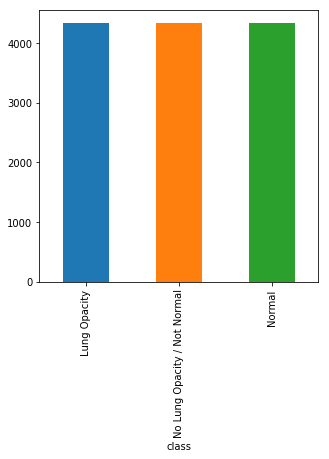

In [33]:
fig, ax1 = plt.subplots(figsize = (5, 5))
train_df.groupby('class').size().plot.bar(ax=ax1) 
print(train_df.shape[0], 'new training size')


In [34]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

Using TensorFlow backend.


In [35]:
import keras_preprocessing.image as KPImage
from PIL import Image

In [36]:
def read_dicom_image(in_path):
    img_arr = dcm.read_file(in_path).pixel_array
    return img_arr/img_arr.max()
    
class medical_pil():
    @staticmethod
    def open(in_path):
        if '.dcm' in in_path:
            c_slice = read_dicom_image(in_path)
            int_slice =  (255*c_slice).clip(0, 255).astype(np.uint8) # 8bit images are more friendly
            return Image.fromarray(int_slice)
        else:
            return Image.open(in_path)
    fromarray = Image.fromarray
KPImage.pil_image = medical_pil

In [37]:
# DATA GENETRAIONS FOR MODEL




img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)




def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen





train_gen = flow_from_dataframe(img_gen, train_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

valid_gen = flow_from_dataframe(img_gen, valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 256) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
valid_X, valid_Y = next(flow_from_dataframe(img_gen, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'class_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = TEST_SAMPLES)) # one big batch






## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 12999 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3853 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 3853 images


(24, 224, 224, 3) (24, 3)


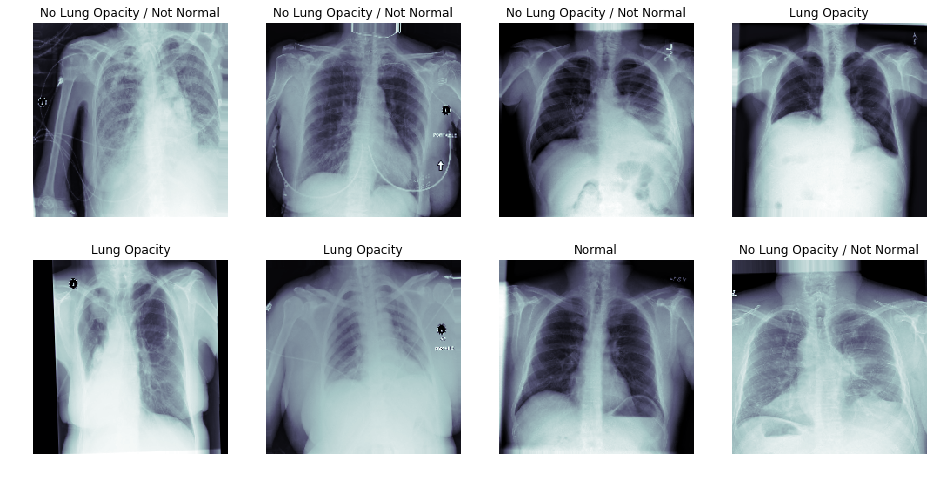

In [38]:
t_x, t_y = next(train_gen)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s' % class_enc.classes_[np.argmax(c_y)])
    c_ax.axis('off')

In [39]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False


51879936/51877672 [==============================] - 28s 1us/step


In [41]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D,LeakyReLU
from keras.models import Model
from keras.optimizers import Adam
pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)
gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'relu')(gap_dr))
#hidd = Dropout(DROPOUT)(Dense(DENSE_COUNT,activation=LeakyRelu)(dr_steps))
#hidd =LeakyReLU(alpha=0.05)(dr_steps)
out_layer = Dense(t_y.shape[1], activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   (None, 7, 7, 1664)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 1664)        6656      
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               213120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total para

In [42]:
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
pneu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
trained_model (Model)        (None, 3)                 220163    
Total params: 12,863,043
Trainable params: 216,835
Non-trainable params: 12,646,208
_________________________________________________________________


In [43]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('lung_opacity')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=10, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/bif/.local/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [44]:
train_gen.batch_size = BATCH_SIZE
pneu_model.fit_generator(train_gen,steps_per_epoch=400, 
                         validation_data = (valid_X, valid_Y), 
                         epochs=20, 
                         callbacks=callbacks_list,
                         workers=2)

Epoch 1/20
400/400 [==============================] - 165s 412ms/step - loss: 0.9036 - categorical_accuracy: 0.5622 - val_loss: 1.5646 - val_categorical_accuracy: 0.3675

Epoch 00001: val_loss improved from inf to 1.56462, saving model to lung_opacity_weights.best.hdf5
Epoch 2/20
400/400 [==============================] - 153s 382ms/step - loss: 0.8189 - categorical_accuracy: 0.6121 - val_loss: 1.6319 - val_categorical_accuracy: 0.3650

Epoch 00002: val_loss did not improve from 1.56462
Epoch 3/20
400/400 [==============================] - 149s 371ms/step - loss: 0.7845 - categorical_accuracy: 0.6356 - val_loss: 1.7210 - val_categorical_accuracy: 0.3700

Epoch 00003: val_loss did not improve from 1.56462
Epoch 4/20
400/400 [==============================] - 149s 371ms/step - loss: 0.7882 - categorical_accuracy: 0.6278 - val_loss: 1.5807 - val_categorical_accuracy: 0.3938

Epoch 00004: val_loss did not improve from 1.56462
Epoch 5/20
400/400 [==============================] - 150s 376ms

In [45]:
pneu_model.load_weights(weight_path)
pneu_model.save('full_model.h5')

In [46]:
pred_Y = pneu_model.predict(valid_X, 
                          batch_size = BATCH_SIZE, 
                          verbose = True)

800/800 [==============================] - 15s 19ms/step


                              precision    recall  f1-score   support

                Lung Opacity       0.59      0.23      0.34       179
No Lung Opacity / Not Normal       0.47      0.05      0.08       351
                      Normal       0.39      1.00      0.56       270

                 avg / total       0.47      0.41      0.30       800



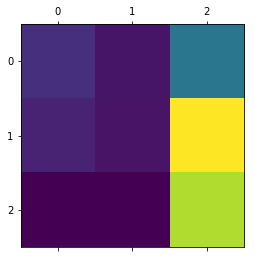

In [47]:
from sklearn.metrics import classification_report, confusion_matrix
plt.matshow(confusion_matrix(np.argmax(valid_Y, -1), np.argmax(pred_Y,-1)))
print(classification_report(np.argmax(valid_Y, -1), 
                            np.argmax(pred_Y,-1), target_names = class_enc.classes_))

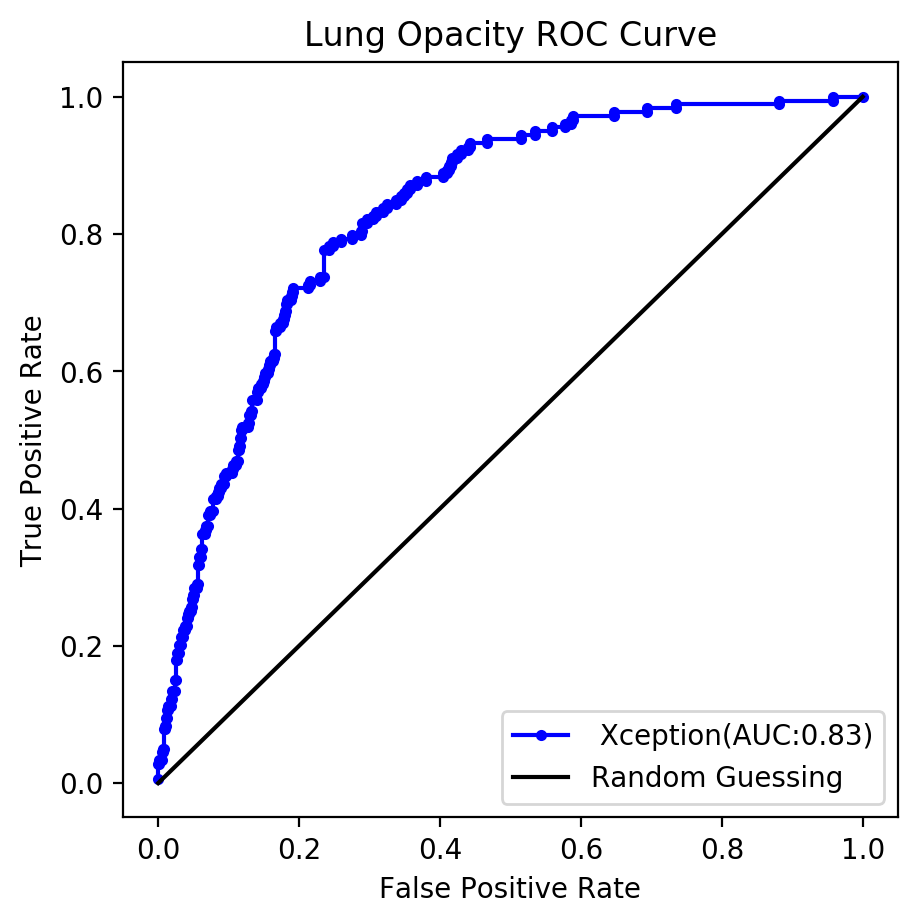

In [48]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(np.argmax(valid_Y,-1)==0, pred_Y[:,0])
fig, ax1 = plt.subplots(1,1, figsize = (5, 5), dpi = 200)
ax1.plot(fpr, tpr, 'b.-', label = ' Xception(AUC:%2.2f)' % roc_auc_score(np.argmax(valid_Y,-1)==0, pred_Y[:,0]))
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend(loc = 4)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');
ax1.set_title('Lung Opacity ROC Curve')
fig.savefig('roc_valid.pdf')

In [ ]:
import keras
model = keras.models.load_model('/home/bif/Hello/full_model.h5')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img = dcm.read_file('/home/bif/Hello/stage_1_test_images/001916b8-3d30-4935-a5d1-8eaddb1646cd.dcm')
flow_from_dataframe(img_gen, 
                     img, 
                    path_col = 'path',
                y_col = 'patientId', 
                target_size = IMG_SIZE,
                color_mode = 'rgb'
                        )
classes = model.predict_classes(img)

print(classes)

In [65]:
test_img_df = pd.DataFrame({'path': 
              glob.glob('/home/bif/Hello/stage_1_test_images/*.dcm')})
test_img_df['patientId'] = test_img_df['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
test_img_df.sample(4)

,path,patientId
82,/home/bif/Hello/stage_1_test_images/0422a993-6...,0422a993-6daa-43b9-aa54-80104541f539
140,/home/bif/Hello/stage_1_test_images/2232fe6c-e...,2232fe6c-e152-4875-9b6d-1706a3b1652c
35,/home/bif/Hello/stage_1_test_images/265fdc5a-6...,265fdc5a-6b13-4ec0-a13c-81ac83bc3865
972,/home/bif/Hello/stage_1_test_images/2cc72d62-1...,2cc72d62-1144-4fe9-a4ab-da083ad11392


In [67]:
submission_gen = flow_from_dataframe(img_gen, 
                                     test_img_df, 
                             path_col = 'path',
                            y_col = 'patientId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE,
                                    shuffle=False)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1000 images


In [68]:
from tqdm import tqdm
test_steps = 2*test_img_df.shape[0]//BATCH_SIZE
out_ids, out_vec = [], []
for _, (t_x, t_y) in zip(tqdm(range(test_steps)), submission_gen):
    out_vec += [pneu_model.predict(t_x)]
    out_ids += [t_y]
out_vec = np.concatenate(out_vec, 0)
out_ids = np.concatenate(out_ids, 0)

100%|██████████| 83/83 [01:09<00:00,  1.16it/s]


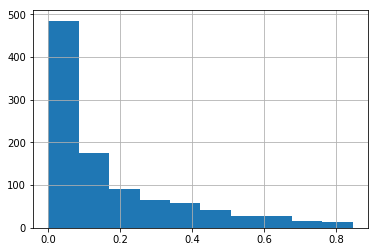

In [70]:
pred_df = pd.DataFrame(out_vec, columns=class_enc.classes_)
pred_df['patientId'] = out_ids
pred_avg_df = pred_df.groupby('patientId').agg('mean').reset_index()
pred_avg_df['Lung Opacity'].hist()
#pred_avg_df.to_csv('image_level_class_probs.csv', index=False) # not hte submission file



In [71]:
pred_avg_df

,patientId,Lung Opacity,No Lung Opacity / Not Normal,Normal
0,000924cf-0f8d-42bd-9158-1af53881a557,0.046329,0.100849,0.852822
1,000db696-cf54-4385-b10b-6b16fbb3f985,0.474757,0.451242,0.074001
2,000fe35a-2649-43d4-b027-e67796d412e0,0.845765,0.133964,0.020271
3,001031d9-f904-4a23-b3e5-2c088acd19c6,0.054001,0.180178,0.765821
4,0010f549-b242-4e94-87a8-57d79de215fc,0.012976,0.053895,0.933130
5,001916b8-3d30-4935-a5d1-8eaddb1646cd,0.336072,0.398115,0.265813
6,0022073f-cec8-42ec-ab5f-bc2314649235,0.519322,0.353148,0.127531
7,0022995a-45eb-4cfa-9a59-cd15f5196c64,0.004237,0.050881,0.944882
8,0025d2de-bd78-4d36-9f72-e15a5e22ca82,0.045998,0.159153,0.794850
9,00293de0-a530-41dc-9621-0b3def01d06d,0.027168,0.138883,0.833948


In [114]:
pred_avg_df['PredictionString'] = pred_avg_df['Lung Opacity'].map(lambda x: ('%2.2f 0 0 1024 1024' % x) if x>0.5 else '')

In [116]:
pred_avg_df[['patientId', 'PredictionString']].to_csv('submission.csv', index=False)